In [1]:
import requests
import pandas as pd
import numpy as np
import json
import quandl
import urllib
from dotenv import load_dotenv
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import os package
import os

#load envs
load_dotenv()

#read in api keys
quandl_api_key = os.getenv("QUANDL_API_KEY")
type(quandl_api_key)

#set key for quandl
quandl.ApiConfig.api_key = quandl_api_key

%matplotlib inline

In [2]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth',None)

#census url
msa_to_msa_url = 'https://api.census.gov/data/2018/acs/flows?get=MOVEDIN,GEOID1,GEOID2,MOVEDOUT,FULL1_NAME,FULL2_NAME,\
MOVEDNET&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*'

In [3]:
response_data = requests.get(msa_to_msa_url).json()
df = pd.DataFrame(response_data)

#cleanup
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header #set the header row as the df header
len(df)

70428

### Cleanup Census Data

In [4]:
#change 'None' to 0
df['MOVEDNET'].fillna(0,inplace=True)

#convert to ints
df['MOVEDNET'] = df['MOVEDNET'].astype(int)

df[df['FULL1_NAME'].str.contains('Abilene')].tail(10)

,MOVEDIN,GEOID1,GEOID2,MOVEDOUT,FULL1_NAME,FULL2_NAME,MOVEDNET,metropolitan statistical area/micropolitan statistical area
139,0,10180,47020,22,"Abilene, TX Metro Area","Victoria, TX Metro Area",-22,10180
140,23,10180,47260,8,"Abilene, TX Metro Area","Virginia Beach-Norfolk-Newport News, VA-NC Metro Area",15,10180
141,116,10180,47380,85,"Abilene, TX Metro Area","Waco, TX Metro Area",31,10180
142,55,10180,47900,109,"Abilene, TX Metro Area","Washington-Arlington-Alexandria, DC-VA-MD-WV Metro Area",-54,10180
143,10,10180,47940,0,"Abilene, TX Metro Area","Waterloo-Cedar Falls, IA Metro Area",10,10180
144,0,10180,48260,7,"Abilene, TX Metro Area","Weirton-Steubenville, WV-OH Metro Area",-7,10180
145,53,10180,48620,0,"Abilene, TX Metro Area","Wichita, KS Metro Area",53,10180
146,347,10180,48660,271,"Abilene, TX Metro Area","Wichita Falls, TX Metro Area",76,10180
147,0,10180,49620,16,"Abilene, TX Metro Area","York-Hanover, PA Metro Area",-16,10180
148,0,10180,49740,9,"Abilene, TX Metro Area","Yuma, AZ Metro Area",-9,10180


## Include County FIPS dictionary for all USA Counties
### Allows for lookups 

In [5]:
#pull in county dictionary to lookup
df_counties = pd.read_csv('resources/usa_counties.csv',converters={'State Code (FIPS)': lambda x: str(x), 'County Code (FIPS)': lambda x: str(x)})  #keeps leading zeros
df_counties.columns
df_counties = df_counties.rename(columns={'State Code (FIPS)':'state_fips', 'County Code (FIPS)':'county_fips'})
df_counties['fips'] = df_counties['state_fips'].astype(str) + df_counties['county_fips'].astype(str)

df_counties = df_counties[df_counties['Summary Level'] == 50] #limit to state/counties
df_counties.head()

,Summary Level,state_fips,county_fips,County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS),Area Name (including legal/statistical area description),fips
2,50,01,001,0,0,0,Autauga County,01001
3,50,01,003,0,0,0,Baldwin County,01003
4,50,01,005,0,0,0,Barbour County,01005
5,50,01,007,0,0,0,Bibb County,01007
6,50,01,009,0,0,0,Blount County,01009


### Aggregate MovedNet / Total Population Gained per MSA
#### Display Top 10 Cities that gained in migration
Shows the total net gain/loss of each MSA (metropolitan statistical area) from 2014-2018

In [6]:
#Group MSA by GEOID1 AND NAME (AKA:CBSACode)
by_MSA = df.groupby(by=['GEOID1','FULL1_NAME'])

df_msa = by_MSA.agg(
    {'MOVEDNET' : np.sum}
    )
df_msa.head()
df_msa.sort_values('MOVEDNET',ascending=False,inplace=True)
df_msa.head()

,,MOVEDNET
GEOID1,FULL1_NAME,
38060,"Phoenix-Mesa-Scottsdale, AZ Metro Area",48585
40140,"Riverside-San Bernardino-Ontario, CA Metro Area",35809
36740,"Orlando-Kissimmee-Sanford, FL Metro Area",34233
19100,"Dallas-Fort Worth-Arlington, TX Metro Area",28028
12420,"Austin-Round Rock, TX Metro Area",26167


In [7]:
#pull in table that matches zillow region ids with CBSACode info
#cleanup data
df_crosswalk = pd.read_csv('resources/CountyCrossWalk_Zillow_1.csv', dtype={'FIPS': object, 'StateFIPS':object, 'CountyFIPS':object})
df_crosswalk['StateFIPS'] = df_crosswalk['StateFIPS'].apply(lambda x: x.zfill(2))  #fill with leading zeros
df_crosswalk['CountyFIPS'] = df_crosswalk['CountyFIPS'].apply(lambda x: x.zfill(3)) #fill with leading zeros
df_crosswalk['FIPS'] = df_crosswalk['StateFIPS'] + df_crosswalk['CountyFIPS']
df_crosswalk.dropna(subset=['CBSACode'],inplace=True)
df_crosswalk.set_index('CBSACode',inplace=True)
df_crosswalk.index = df_crosswalk.index.astype(int)
df_crosswalk['MetroRegionID_Zillow'] = df_crosswalk['MetroRegionID_Zillow'].astype(int)
idx = df_crosswalk.index
idx.rename('cbsa_code',inplace=True)
df_crosswalk[df_crosswalk['MetroName_Zillow'].str.contains('Phoenix')]

,CountyName,StateName,StateFIPS,CountyFIPS,MetroName_Zillow,CBSAName,CountyRegionID_Zillow,MetroRegionID_Zillow,FIPS
cbsa_code,,,,,,,,,
38060,Maricopa,Arizona,04,013,"Phoenix, AZ","Phoenix-Mesa-Scottsdale, AZ",2402,394976,04013
38060,Pinal,Arizona,04,021,"Phoenix, AZ","Phoenix-Mesa-Scottsdale, AZ",685,394976,04021


## Harvest Real Estate Data from Quandl

In [8]:
#query quandl for region data
df_zillow_regions = quandl.get_table('ZILLOW/REGIONS', paginate=True)
df_zillow_cities = df_zillow_regions.loc[df_zillow_regions['region_type'] == 'city'] ##LIMIT to cities

#rename cols
df_zillow_cities = df_zillow_cities.rename(columns={'region_id':'zillow_region_id'})
#set index
df_zillow_cities.set_index('zillow_region_id',inplace=True)
#head
df_zillow_cities.head()

,region_type,region
zillow_region_id,,
9999,city,Carrsville; VA; Virginia Beach-Norfolk-Newport News; Isle of Wight County
9998,city,Birchleaf; VA; Big Stone Gap; Dickenson County
9994,city,Wright; KS; Dodge City; Ford County
9987,city,Weston; CT; Bridgeport-Stamford-Norwalk; Fairfield County
9980,city,South Wilmington; IL; Chicago-Naperville-Elgin; Grundy County


### Capture top 10 Migrated Cities CBSA Codes

In [9]:
df_top_10 = df_msa.iloc[:10]
codes_top_10 = df_top_10.index.to_list()
codes_top_10

[('38060', 'Phoenix-Mesa-Scottsdale, AZ Metro Area'),
 ('40140', 'Riverside-San Bernardino-Ontario, CA Metro Area'),
 ('36740', 'Orlando-Kissimmee-Sanford, FL Metro Area'),
 ('19100', 'Dallas-Fort Worth-Arlington, TX Metro Area'),
 ('12420', 'Austin-Round Rock, TX Metro Area'),
 ('45300', 'Tampa-St. Petersburg-Clearwater, FL Metro Area'),
 ('29820', 'Las Vegas-Henderson-Paradise, NV Metro Area'),
 ('16740', 'Charlotte-Concord-Gastonia, NC-SC Metro Area'),
 ('17900', 'Columbia, SC Metro Area'),
 ('34980', 'Nashville-Davidson--Murfreesboro--Franklin, TN Metro Area')]

### Loop Through Top 10 Migrated Cities and Grab Zillow Home Values

In [10]:
#loop cities
df_returns = pd.DataFrame()
x = 0
for code, desc in codes_top_10:
        x+=1
        if x == 11:
            break    # break here

        #we have the cbsa code; now need to pull the region code from crosswalk
 
        try:
            
            curr_region = df_crosswalk.loc[int(code)]
            if isinstance(curr_region, pd.DataFrame):
                curr_region_id = curr_region['MetroRegionID_Zillow'].iloc[0]
                curr_cbsa_name = curr_region.loc[int(code)]['CBSAName'].iloc[0]
            else:
                curr_region_id = curr_region['MetroRegionID_Zillow']
                curr_cbsa_name = curr_region['CBSAName']
            curr_region_name = desc
            print(f'{curr_region_id} | {curr_cbsa_name} | {curr_region_name}')
            data = quandl.get_table('ZILLOW/DATA', indicator_id='ZALL', region_id=curr_region_id)
            data.set_index('date',inplace=True)
            data.sort_index(ascending=True,inplace=True)
            data.rename(columns={'value':'Close'},inplace=True)
            data[curr_region_name] = data['Close'].pct_change()

            #add new df to returns df
            df_returns[curr_region_name] = data[curr_region_name]
        except:
            print(f'Error on code {code}')
        finally:
            continue
        

df_returns.head()

394976 | Phoenix-Mesa-Scottsdale, AZ | Phoenix-Mesa-Scottsdale, AZ Metro Area
395025 | Riverside-San Bernardino-Ontario, CA | Riverside-San Bernardino-Ontario, CA Metro Area
394943 | Orlando-Kissimmee-Sanford, FL | Orlando-Kissimmee-Sanford, FL Metro Area
394514 | Dallas-Fort Worth-Arlington, TX | Dallas-Fort Worth-Arlington, TX Metro Area
394355 | Austin-Round Rock, TX | Austin-Round Rock, TX Metro Area
395148 | Tampa-St. Petersburg-Clearwater, FL | Tampa-St. Petersburg-Clearwater, FL Metro Area
394775 | Las Vegas-Henderson-Paradise, NV | Las Vegas-Henderson-Paradise, NV Metro Area
394458 | Charlotte-Concord-Gastonia, NC-SC | Charlotte-Concord-Gastonia, NC-SC Metro Area
394486 | Columbia, SC | Columbia, SC Metro Area
394902 | Nashville-Davidson--Murfreesboro--Franklin, TN | Nashville-Davidson--Murfreesboro--Franklin, TN Metro Area


,"Phoenix-Mesa-Scottsdale, AZ Metro Area","Riverside-San Bernardino-Ontario, CA Metro Area","Orlando-Kissimmee-Sanford, FL Metro Area","Dallas-Fort Worth-Arlington, TX Metro Area","Austin-Round Rock, TX Metro Area","Tampa-St. Petersburg-Clearwater, FL Metro Area","Las Vegas-Henderson-Paradise, NV Metro Area","Charlotte-Concord-Gastonia, NC-SC Metro Area","Columbia, SC Metro Area","Nashville-Davidson--Murfreesboro--Franklin, TN Metro Area"
date,,,,,,,,,,
1996-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-02-29,0.002797,-0.004093,0.000816,0.000566,-0.005071,0.000290,-0.000919,0.001620,0.000897,0.002959
1996-03-31,0.003169,-0.002543,0.001397,0.001428,-0.007310,0.000122,0.000609,0.001786,0.000574,0.003359
1996-04-30,0.006085,-0.005477,0.002163,0.002862,-0.010499,0.001180,-0.000099,0.003852,0.001550,0.006514
1996-05-31,0.005912,-0.004126,0.002897,0.003059,-0.002790,0.001813,0.000999,0.003770,0.001387,0.006575


#### Display Cum Returns by MSA

In [11]:
#limit to 2014-2018
df_returns = df_returns.loc['2014-01-01':'2018-12-31']

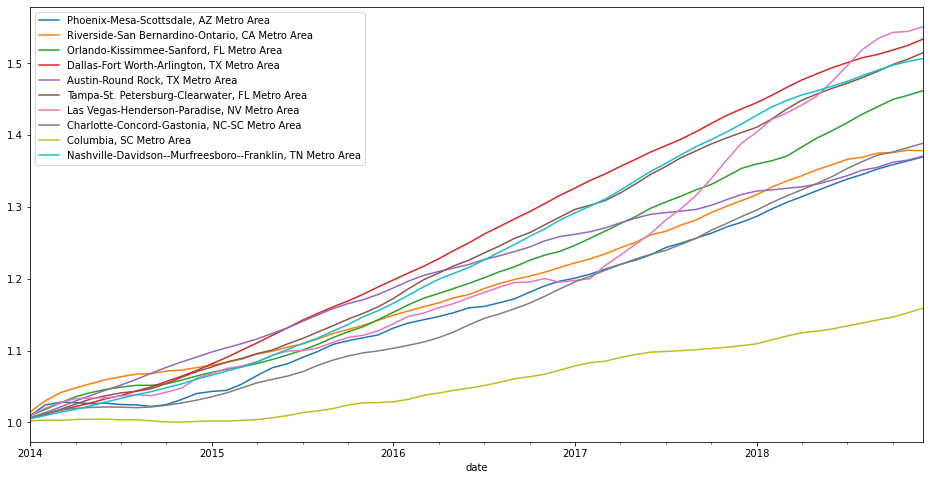

In [12]:
df_returns.dropna(inplace=True)
cum_returns = (1. + df_returns).cumprod()
cum_returns.dropna(inplace=True)
cum_returns.plot(figsize=(16,8))

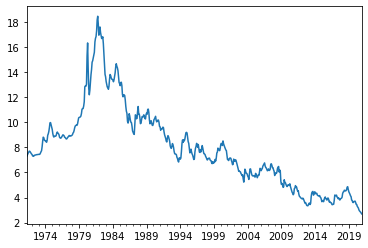

In [13]:
#get mortgage rates
df_rates = quandl.get("FMAC/30US", authtoken=quandl_api_key)
df_rates.columns = ['Rate']

df_rates.index = [pd.datetime(x.year, x.month, 1) for x in df_rates.index.tolist()] 
df_rates = df_rates.groupby(df_rates.index)['Rate'].mean()
df_rates.plot()

## UNEMPLOYMENT DATA

In [14]:
df_unemployment = pd.read_csv('https://raw.githubusercontent.com/szx868/FinalProject/master/Unemployment_Rate_by_County_Percent.csv')
df_unemployment.columns
df_unemployment.rename(columns={'Region Code':'fips'},inplace=True)
df_unemployment.head()

,Series ID,Region Name,fips,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,SCABBE1URN,"Abbeville County, SC",45001,3.8,6.6,7.7,9.1,8.2,7.7,8.8,8.1,8.1,14.2,13.6,12.5,10.6,9.5,7.7,6.9,5.5,4.6,4.2
1,LAACAD0URN,"Acadia Parish, LA",22001,5.8,6.0,6.3,6.8,5.8,6.1,3.6,3.8,4.2,6.5,7.3,6.7,6.0,6.0,5.8,6.9,7.4,5.9,5.4
2,VAACCO1URN,"Accomack County, VA",51001,3.0,3.4,4.2,4.4,4.7,4.7,4.3,4.1,5.0,6.5,7.9,8.4,7.9,7.2,6.7,5.5,5.0,4.9,4.1
3,IDADAC1URN,"Ada County, ID",16001,3.4,3.9,4.7,4.9,4.1,3.3,2.7,2.7,4.9,8.9,8.3,7.3,6.2,5.2,4.2,3.7,3.3,2.8,2.4
4,OKADAI1URN,"Adair County, OK",40001,3.5,4.1,4.8,7.8,6.2,4.8,4.4,4.7,4.9,8.0,10.5,9.2,9.1,9.8,8.0,6.1,5.9,5.0,4.4


### CRIME DATA

In [15]:
#file_path = Path("../Resources/amd_stock_data.csv")
#df_crime = pd.read_csv('')

dfs = []
for x in range(2014,2019):  #import crime 2014-2018
     file_path = Path("resources/crime_data/offenses_known_monthly_"+str(x)+".csv")
     dfs.append(pd.read_csv(file_path, dtype={'fips_state_county_code': object}))

big_frame = pd.concat(dfs,ignore_index=True)


In [54]:
#big_frame[big_frame['fips_state_county_code'] == '48453']]
big_frame[(big_frame['fips_state_county_code'] == '48453') & (big_frame['core_city_indication']=='core city of msa')].head(10)

,ori,ori9,agency_name,state,state_abb,year,month,date,number_of_months_missing,last_month_reported,month_missing,fips_state_code,fips_county_code,fips_state_county_code,fips_place_code,agency_type,crosswalk_agency_name,census_name,population_group,population_1,population_1_county,population_2,population_2_county,population_3,population_3_county,population,country_division,juvenile_age,core_city_indication,last_update,fbi_field_office,followup_indication,zip_code,date_of_last_update,month_included_in,covered_by_ori,agency_count,special_mailing_group,special_mailing_address,first_line_of_mailing_address,second_line_of_mailing_address,third_line_of_mailing_address,fourth_line_of_mailing_address,card_unfound_type,card_actual_type,card_tot_clr_type,card_clr_18_type,card_officers_type,card_unfound_pt,card_actual_pt,card_tot_clr_pt,card_clr_18_pt,officers_killed_by_felony,officers_killed_by_accident,officers_assaulted,actual_murder,actual_manslaughter,actual_rape_total,actual_rape_by_force,actual_rape_attempted,actual_robbery_total,actual_robbery_with_a_gun,actual_robbery_with_a_knife,actual_robbery_other_weapon,actual_robbery_unarmed,actual_assault_total,actual_assault_with_a_gun,actual_assault_with_a_knife,actual_assault_other_weapon,actual_assault_unarmed,actual_assault_simple,actual_burg_total,actual_burg_force_entry,actual_burg_nonforce_entry,actual_burg_attempted,actual_theft_total,actual_mtr_veh_theft_total,actual_mtr_veh_theft_car,actual_mtr_veh_theft_truck,actual_mtr_veh_theft_other,actual_all_crimes,actual_assault_aggravated,actual_index_violent,actual_index_property,actual_index_total,tot_clr_murder,tot_clr_manslaughter,tot_clr_rape_total,tot_clr_rape_by_force,tot_clr_rape_attempted,tot_clr_robbery_total,tot_clr_robbery_with_a_gun,tot_clr_robbery_with_a_knife,tot_clr_robbery_other_weapon,tot_clr_robbery_unarmed,tot_clr_assault_total,tot_clr_assault_with_a_gun,tot_clr_assault_with_a_knife,tot_clr_assault_other_weapon,tot_clr_assault_unarmed,tot_clr_assault_simple,tot_clr_burg_total,tot_clr_burg_force_entry,tot_clr_burg_nonforce_entry,tot_clr_burg_attempted,tot_clr_theft_total,tot_clr_mtr_veh_theft_total,tot_clr_mtr_veh_theft_car,tot_clr_mtr_veh_theft_truck,tot_clr_mtr_veh_theft_other,tot_clr_all_crimes,tot_clr_assault_aggravated,tot_clr_index_violent,tot_clr_index_property,tot_clr_index_total,clr_18_murder,clr_18_manslaughter,clr_18_rape_total,clr_18_rape_by_force,clr_18_rape_attempted,clr_18_robbery_total,clr_18_robbery_with_a_gun,clr_18_robbery_with_a_knife,clr_18_robbery_other_weapon,clr_18_robbery_unarmed,clr_18_assault_total,clr_18_assault_with_a_gun,clr_18_assault_with_a_knife,clr_18_assault_other_weapon,clr_18_assault_unarmed,clr_18_assault_simple,clr_18_burg_total,clr_18_burg_force_entry,clr_18_burg_nonforce_entry,clr_18_burg_attempted,clr_18_theft_total,clr_18_mtr_veh_theft_total,clr_18_mtr_veh_theft_car,clr_18_mtr_veh_theft_truck,clr_18_mtr_veh_theft_other,clr_18_all_crimes,clr_18_assault_aggravated,clr_18_index_violent,clr_18_index_property,clr_18_index_total,unfound_murder,unfound_manslaughter,unfound_rape_total,unfound_rape_by_force,unfound_rape_attempted,unfound_robbery_total,unfound_robbery_with_a_gun,unfound_robbery_with_a_knife,unfound_robbery_other_weapon,unfound_robbery_unarmed,unfound_assault_total,unfound_assault_with_a_gun,unfound_assault_with_a_knife,unfound_assault_other_weapon,unfound_assault_unarmed,unfound_assault_simple,unfound_burg_total,unfound_burg_force_entry,unfound_burg_nonforce_entry,unfound_burg_attempted,unfound_theft_total,unfound_mtr_veh_theft_total,unfound_mtr_veh_theft_car,unfound_mtr_veh_theft_truck,unfound_mtr_veh_theft_other,unfound_all_crimes,unfound_assault_aggravated,unfound_index_violent,unfound_index_property,unfound_index_total,arson_number_of_months_missing,arson_last_month_reported,actual_arson_single_occupancy,actual_arson_other_residential,actual_arson_storage,actual_arson_industrial,actual_arson_other_commercial,actual_arson_community_public,actual_arson_all_oth_structu

In [63]:
#loop through msas and get all the countie data for crime
df_crime = pd.DataFrame()
dataframes = []
for code,desc in codes_top_10:
    
    #get all of the counties from crosswalk
    #print(code)
    _match = df_crosswalk.loc[int(code)]
    _counties = []
    #display(_match)
    if isinstance(_match, pd.DataFrame):
        _counties = _match['FIPS'].tolist()
        _df = big_frame[(big_frame['fips_state_county_code'].isin(_counties))]
    else:
        _counties = _match['FIPS']
        _df = big_frame[(big_frame['fips_state_county_code'] == _counties)]
    #print(_counties)
    #print('\n')
    
    #using list of counties - build out dataframe of murder/index for city
    #_df = big_frame[big_frame['fips_state_county_code']].isin(_counties)

    _df['cbsa_code'] = code
    _df['city_description'] = desc
    
    dataframes.append(_df)
    
len(dataframes)
#    df_new[df_new['l_ext'].isin([31, 22, 30, 25, 64])]
df_crime = pd.concat(dataframes)    

In [64]:
df_crime['date'] = pd.to_datetime(df_crime['date'])
df_crime.set_index(['date','cbsa_code','city_description','fips_state_county_code'],inplace=True)
df_crime.head()

,,,,ori,ori9,agency_name,state,state_abb,year,month,number_of_months_missing,last_month_reported,month_missing,fips_state_code,fips_county_code,fips_place_code,agency_type,crosswalk_agency_name,census_name,population_group,population_1,population_1_county,population_2,population_2_county,population_3,population_3_county,population,country_division,juvenile_age,core_city_indication,last_update,fbi_field_office,followup_indication,zip_code,date_of_last_update,month_included_in,covered_by_ori,agency_count,special_mailing_group,special_mailing_address,first_line_of_mailing_address,second_line_of_mailing_address,third_line_of_mailing_address,fourth_line_of_mailing_address,card_unfound_type,card_actual_type,card_tot_clr_type,card_clr_18_type,card_officers_type,card_unfound_pt,card_actual_pt,card_tot_clr_pt,card_clr_18_pt,officers_killed_by_felony,officers_killed_by_accident,officers_assaulted,actual_murder,actual_manslaughter,actual_rape_total,actual_rape_by_force,actual_rape_attempted,actual_robbery_total,actual_robbery_with_a_gun,actual_robbery_with_a_knife,actual_robbery_other_weapon,actual_robbery_unarmed,actual_assault_total,actual_assault_with_a_gun,actual_assault_with_a_knife,actual_assault_other_weapon,actual_assault_unarmed,actual_assault_simple,actual_burg_total,actual_burg_force_entry,actual_burg_nonforce_entry,actual_burg_attempted,actual_theft_total,actual_mtr_veh_theft_total,actual_mtr_veh_theft_car,actual_mtr_veh_theft_truck,actual_mtr_veh_theft_other,actual_all_crimes,actual_assault_aggravated,actual_index_violent,actual_index_property,actual_index_total,tot_clr_murder,tot_clr_manslaughter,tot_clr_rape_total,tot_clr_rape_by_force,tot_clr_rape_attempted,tot_clr_robbery_total,tot_clr_robbery_with_a_gun,tot_clr_robbery_with_a_knife,tot_clr_robbery_other_weapon,tot_clr_robbery_unarmed,tot_clr_assault_total,tot_clr_assault_with_a_gun,tot_clr_assault_with_a_knife,tot_clr_assault_other_weapon,tot_clr_assault_unarmed,tot_clr_assault_simple,tot_clr_burg_total,tot_clr_burg_force_entry,tot_clr_burg_nonforce_entry,tot_clr_burg_attempted,tot_clr_theft_total,tot_clr_mtr_veh_theft_total,tot_clr_mtr_veh_theft_car,tot_clr_mtr_veh_theft_truck,tot_clr_mtr_veh_theft_other,tot_clr_all_crimes,tot_clr_assault_aggravated,tot_clr_index_violent,tot_clr_index_property,tot_clr_index_total,clr_18_murder,clr_18_manslaughter,clr_18_rape_total,clr_18_rape_by_force,clr_18_rape_attempted,clr_18_robbery_total,clr_18_robbery_with_a_gun,clr_18_robbery_with_a_knife,clr_18_robbery_other_weapon,clr_18_robbery_unarmed,clr_18_assault_total,clr_18_assault_with_a_gun,clr_18_assault_with_a_knife,clr_18_assault_other_weapon,clr_18_assault_unarmed,clr_18_assault_simple,clr_18_burg_total,clr_18_burg_force_entry,clr_18_burg_nonforce_entry,clr_18_burg_attempted,clr_18_theft_total,clr_18_mtr_veh_theft_total,clr_18_mtr_veh_theft_car,clr_18_mtr_veh_theft_truck,clr_18_mtr_veh_theft_other,clr_18_all_crimes,clr_18_assault_aggravated,clr_18_index_violent,clr_18_index_property,clr_18_index_total,unfound_murder,unfound_manslaughter,unfound_rape_total,unfound_rape_by_force,unfound_rape_attempted,unfound_robbery_total,unfound_robbery_with_a_gun,unfound_robbery_with_a_knife,unfound_robbery_other_weapon,unfound_robbery_unarmed,unfound_assault_total,unfound_assault_with_a_gun,unfound_assault_with_a_knife,unfound_assault_other_weapon,unfound_assault_unarmed,unfound_assault_simple,unfound_burg_total,unfound_burg_force_entry,unfound_burg_nonforce_entry,unfound_burg_attempted,unfound_theft_total,unfound_mtr_veh_theft_total,unfound_mtr_veh_theft_car,unfound_mtr_veh_theft_truck,unfound_mtr_veh_theft_other,unfound_all_crimes,unfound_assault_aggravated,unfound_index_violent,unfound_index_property,unfound_index_total,arson_number_of_months_missing,arson_last_month_reported,actual_arson_single_occupancy,actual_arson_other_residential,actual_arson_storage,actual_arson_industrial,actual_arson_other_commercial,actual_arson_community_public,actual_arson_all_oth_structures,actual_arson_total_st

In [65]:
#drop all columns but following
df_crime.drop(df_crime.columns.difference(['population_group','population','actual_all_crimes','actual_index_violent','actual_murder']), 1, inplace=True)
df_crime.sort_values(['date','cbsa_code'],inplace=True)
df_crime.head(20)

population_group  \
date       cbsa_code city_description                 fips_state_county_code                                  
2014-01-01 12420     Austin-Round Rock, TX Metro Area 48453                     non-msa county under 10,000   
                                                      48021                   msa-county 25,000 thru 99,999   
                                                      48021                           city 2,500 thru 9,999   
                                                      48021                           city 2,500 thru 9,999   
                                                      48021                           city 2,500 thru 9,999   
                                                      48491                           city 2,500 thru 9,999   
                                                      48055                   msa-county 10,000 thru 24,999   
                                                      48055                         city 10,000 thru 24,999   
                                                      48055                           city 2,500 thru 9,999   
                                                      48055                                city under 2,500   
                                                      48209                   msa-county 25,000 thru 99,999   
                                                      48209                         city 50,000 thru 99,999   
                                                      48209                                city under 2,500   
                                                      48209                         city 25,000 thru 49,999   
                                                      48209                         city 10,000 thru 24,999   
                                                      48453                             msa-county 100,000+   
                                                      48453                       city 500,000 thru 999,999   
                                                      48453                           city 2,500 thru 9,999   
                                                      48453                                city under 2,500   
                                                      48453                           city 2,500 thru 9,999   

                                                                              population  \
date       cbsa_code city_description                 fips_state_county_code               
2014-01-01 12420     Austin-Round Rock, TX Metro Area 48453                            0   
                                                      48021                        57644   
                                                      48021                         7635   
                                                      48021                         8484   
                                                      48021                         3953   
                                                      48491                         2751   
                                                      48055                        19277   
                                                      48055                        13185   
                                                      48055                         5722   
                                                      48055                         1171   
                                                      48209                        81811   
                                                      48209                        56623   
                                                      48209                            0   
                                                      48209                        32649   
                                                      48209                        11020   
                                                      48453                       20

In [66]:
#df_crime.sort_values(['city_description','population']).head(100)

In [69]:
#group by 
df_crime_by_city = df_crime.groupby(
    ['date', 'cbsa_code','city_description']
).agg(
    {
        # Find the min, max, and sum of the duration column
        'population': "sum",
        'actual_murder':"sum",
        # find the number of network type entries
        'actual_all_crimes': "sum",
        # minimum, first, and number of unique dates
        'actual_index_violent': "mean"
    }
)
df_crime_by_city.tail(10)

population  \
date       cbsa_code city_description                                                        
2018-12-01 12420     Austin-Round Rock, TX Metro Area                              2173033   
           16740     Charlotte-Concord-Gastonia, NC-SC Metro Area                  2576452   
           17900     Columbia, SC Metro Area                                        834324   
           19100     Dallas-Fort Worth-Arlington, TX Metro Area                    7500561   
           29820     Las Vegas-Henderson-Paradise, NV Metro Area                   2236094   
           34980     Nashville-Davidson--Murfreesboro--Franklin, TN Metro Area     1942634   
           36740     Orlando-Kissimmee-Sanford, FL Metro Area                      2568290   
           38060     Phoenix-Mesa-Scottsdale, AZ Metro Area                        4876829   
           40140     Riverside-San Bernardino-Ontario, CA Metro Area               4598111   
           45300     Tampa-St. Petersburg-Clearwater, FL Metro Area                3140906   

                                                                                actual_murder  \
date       cbsa_code city_description                                                           
2018-12-01 12420     Austin-Round Rock, TX Metro Area                                       2   
           16740     Charlotte-Concord-Gastonia, NC-SC Metro Area                           9   
           17900     Columbia, SC Metro Area                                                6   
           19100     Dallas-Fort Worth-Arlington, TX Metro Area                            26   
           29820     Las Vegas-Henderson-Paradise, NV Metro Area                           10   
           34980     Nashville-Davidson--Murfreesboro--Franklin, TN Metro Area             18   
           36740     Orlando-Kissimmee-Sanford, FL Metro Area                               0   
           38060     Phoenix-Mesa-Scottsdale, AZ Metro Area                                17   
           40140     Riverside-San Bernardino-Ontario, CA Metro Area                       21   
           45300     Tampa-St. Petersburg-Clearwater, FL Metro Area                         0   

                                                                                actual_all_crimes  \
date       cbsa_code city_description                                                               
2018-12-01 12420     Austin-Round Rock, TX Metro Area                                      6706.0   
           16740     Charlotte-Concord-Gastonia, NC-SC Metro Area                          8404.0   
           17900     Columbia, SC Metro Area                                               3699.0   
           19100     Dallas-Fort Worth-Arlington, TX Metro Area                           22338.0   
           29820     Las Vegas-Henderson-Paradise, NV Metro Area                           8687.0   
           34980     Nashville-Davidson--Murfreesboro--Franklin, TN Metro Area             7540.0   
           36740     Orlando-Kissimmee-Sanford, FL Metro Area                                 0.0   
           38060     Phoenix-Mesa-Scottsdale, AZ Metro Area                               16519.0   
           40140     Riverside-San Bernardino-Ontario, CA Metro Area                      13504.0   
           45300     Tampa-St. Petersburg-Clearwater, FL Metro Area                           0.0   

                                                                                actual_index_violent  
date       cbsa_code city_description                                                                 
2018-12-01 12420     Austin-Round Rock, TX Metro Area                                      11.386364  
           16740     Charlotte-Concord-Gastonia, NC-SC Metro Area                           8.117647  
           17900     Columbia, SC Metro Area                                                4.987342  
           19100     Dallas-Fort Worth-Arlington, TX Metro

In [68]:
df_crime_by_city.tail(10)

population  \
date       cbsa_code city_description                                                        
2018-12-01 12420     Austin-Round Rock, TX Metro Area                              2173033   
           16740     Charlotte-Concord-Gastonia, NC-SC Metro Area                  2576452   
           17900     Columbia, SC Metro Area                                        834324   
           19100     Dallas-Fort Worth-Arlington, TX Metro Area                    7500561   
           29820     Las Vegas-Henderson-Paradise, NV Metro Area                   2236094   
           34980     Nashville-Davidson--Murfreesboro--Franklin, TN Metro Area     1942634   
           36740     Orlando-Kissimmee-Sanford, FL Metro Area                      2568290   
           38060     Phoenix-Mesa-Scottsdale, AZ Metro Area                        4876829   
           40140     Riverside-San Bernardino-Ontario, CA Metro Area               4598111   
           45300     Tampa-St. Petersburg-Clearwater, FL Metro Area                3140906   

                                                                                actual_murder  \
date       cbsa_code city_description                                                           
2018-12-01 12420     Austin-Round Rock, TX Metro Area                                       2   
           16740     Charlotte-Concord-Gastonia, NC-SC Metro Area                           9   
           17900     Columbia, SC Metro Area                                                6   
           19100     Dallas-Fort Worth-Arlington, TX Metro Area                            26   
           29820     Las Vegas-Henderson-Paradise, NV Metro Area                           10   
           34980     Nashville-Davidson--Murfreesboro--Franklin, TN Metro Area             18   
           36740     Orlando-Kissimmee-Sanford, FL Metro Area                               0   
           38060     Phoenix-Mesa-Scottsdale, AZ Metro Area                                17   
           40140     Riverside-San Bernardino-Ontario, CA Metro Area                       21   
           45300     Tampa-St. Petersburg-Clearwater, FL Metro Area                         0   

                                                                                actual_all_crimes  \
date       cbsa_code city_description                                                               
2018-12-01 12420     Austin-Round Rock, TX Metro Area                                      6706.0   
           16740     Charlotte-Concord-Gastonia, NC-SC Metro Area                          8404.0   
           17900     Columbia, SC Metro Area                                               3699.0   
           19100     Dallas-Fort Worth-Arlington, TX Metro Area                           22338.0   
           29820     Las Vegas-Henderson-Paradise, NV Metro Area                           8687.0   
           34980     Nashville-Davidson--Murfreesboro--Franklin, TN Metro Area             7540.0   
           36740     Orlando-Kissimmee-Sanford, FL Metro Area                                 0.0   
           38060     Phoenix-Mesa-Scottsdale, AZ Metro Area                               16519.0   
           40140     Riverside-San Bernardino-Ontario, CA Metro Area                      13504.0   
           45300     Tampa-St. Petersburg-Clearwater, FL Metro Area                           0.0   

                                                                                actual_index_violent  
date       cbsa_code city_description                                                                 
2018-12-01 12420     Austin-Round Rock, TX Metro Area                                      11.386364  
           16740     Charlotte-Concord-Gastonia, NC-SC Metro Area                           8.117647  
           17900     Columbia, SC Metro Area                                                4.987342  
           19100     Dallas-Fort Worth-Arlington, TX Metro